In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os

In [1]:
# load data
desc_string = 'descriptors/*/desc.npy'
dpdata_name = "FeCHO-clean-v2-7-20873"
dpdata_path = "./data-clean-v2-7-20873-npy"
dpdata_string = "O*"

In [29]:
# define used function
def extract_elements_array(data: dpdata.LabeledSystem) -> list:
    '''extract elements array from dpdata for draw t-SNE'''
    types = data.data['atom_types']
    names = data.data['atom_names']
    ele_array = [names[ind] for ind in types]
    return ele_array

# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_keys = []
all_desc_atom = []
all_desc_stru = []
for f in glob.glob(desc_string):
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_keys.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    all_desc_atom.append(np.concatenate(one_desc, axis=0))
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    all_desc_stru.append(one_desc_stru)
all_desc_stru = np.concatenate(all_desc_stru, axis=0)
np.shape(all_desc_stru)

Reading descriptor results...


(20873, 136)

In [32]:
all_desc_atom = np.concatenate(all_desc_atom, axis=0)

In [33]:
all_desc_atom.shape

(970512, 136)

In [7]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata = dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

MultiSystems (694 systems containing 20873 frames)

In [8]:
alldata_dict = {}
for lbsys in alldata:
    alldata_dict[lbsys.short_name] = lbsys

# get list of system name
sys_list = []
for keyname in desc_keys:
    target_sys = alldata_dict[keyname]
    for ind in range(target_sys.get_nframes()):
        sys_list.append(f"{keyname}-{ind}")

In [9]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        """
        初始化残差块。
        :param hidden_dim: 隐藏层的维度
        """
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)  # 第一层全连接层
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # 第二层全连接层
        self.relu = nn.ReLU()  # 激活函数

    def forward(self, x):
        """
        前向传播。
        :param x: 输入数据
        :return: 输出数据
        """
        residual = x  # 保存输入作为残差
        out = self.relu(self.fc1(x))  # 通过第一层全连接层和激活函数
        out = self.fc2(out)  # 通过第二层全连接层
        out += residual  # 添加残差连接
        out = self.relu(out)  # 再次通过激活函数
        return out

# 定义带残差连接的目标网络和预测网络
class RNDNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        """
        初始化目标网络和预测网络的架构。
        :param input_dim: 输入数据的维度
        :param output_dim: 输出数据的维度
        :param hidden_dim: 隐藏层的维度, 默认为128
        """
        super(RNDNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # 第一层全连接层
        self.residual_block = ResidualBlock(hidden_dim)  # 残差块
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # 第二层全连接层
        self.relu = nn.ReLU()  # 激活函数

    def forward(self, x):
        """
        前向传播。
        :param x: 输入数据
        :return: 输出数据
        """
        x = self.fc1(x) # 通过第一层全连接层
        x = self.relu(x) # 通过激活函数
        x = self.residual_block(x)  # 通过残差块（包括激活函数）
        x = self.fc2(x)  # 通过第二层全连接层
        return x

In [10]:
# 定义RND模块
class RND:
    def __init__(self, input_dim, output_dim, distance_metric="mse", lr=1e-3):
        """
        初始化RND模块。
        :param input_dim: 输入数据的维度
        :param output_dim: 输出数据的维度
        :param distance_metric: 距离度量方案 ("mse", "kld", "cossim", "ce")
        :param lr: 学习率
        """
        self.target_network = RNDNetwork(input_dim, output_dim)  # 目标网络
        self.predictor_network = RNDNetwork(input_dim, output_dim)  # 预测网络
        self.optimizer = optim.Adam(self.predictor_network.parameters(), lr=lr)  # 优化器
        self.distance_metric = distance_metric  # 距离度量方案
        self.loss_fn = self._get_loss_fn(distance_metric)  # 损失函数

    def _get_loss_fn(self, distance_metric):
        """
        根据距离度量方案选择损失函数。
        :param distance_metric: 距离度量方案
        :return: 对应的损失函数
        """
        if distance_metric == "kld":
            softmax = nn.Softmax(dim=-1)
            log_softmax = nn.LogSoftmax(dim=-1)
            kld_novelty_func = lambda target, pred: torch.sum(softmax(target) * (log_softmax(target) - log_softmax(pred)), dim=-1)
            return kld_novelty_func
        elif distance_metric == "mse":
            return nn.MSELoss(reduction='none')
        elif distance_metric == "cossim":
            return lambda target, pred: -(nn.CosineSimilarity(dim=-1)(target, pred) - 1)  # 修复维度问题
        elif distance_metric == "ce":
            softmax = nn.Softmax(dim=-1)
            log_softmax = nn.LogSoftmax(dim=-1)
            return lambda target, pred: -torch.sum(softmax(target) * log_softmax(pred), dim=-1)
        else:
            raise ValueError(f"Unknown distance metric: {distance_metric}")

    def get_intrinsic_reward(self, state):
        """
        计算内在奖励。
        :param state: 输入状态
        :return: 内在奖励值
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # 将输入数据转换为张量并增加批次维度
        target_output = self.target_network(state).detach()  # 目标网络的输出
        predictor_output = self.predictor_network(state)  # 预测网络的输出
        if self.distance_metric == "mse":
            intrinsic_reward = torch.sum(self.loss_fn(predictor_output, target_output), dim=-1).item()
        else:
            intrinsic_reward = torch.mean(self.loss_fn(target_output, predictor_output)).item()
        return intrinsic_reward

    def update_predictor(self, state):
        """
        更新预测网络。
        :param state: 输入状态
        :return: 当前批次的损失值
        """
        state = torch.FloatTensor(state).unsqueeze(0)  # 将输入数据转换为张量并增加批次维度
        target_output = self.target_network(state).detach()  # 目标网络的输出
        predictor_output = self.predictor_network(state)  # 预测网络的输出
        if self.distance_metric == "mse":
            loss = torch.mean(self.loss_fn(predictor_output, target_output))
        else:
            loss = torch.mean(self.loss_fn(target_output, predictor_output))
        self.optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        self.optimizer.step()  # 更新参数
        return loss.item()  # 返回当前批次的损失值

In [ ]:
import logging
import time
from torch.optim.lr_scheduler import ExponentialLR

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rnd_training.log"),  # 输出到文件
        logging.StreamHandler()  # 输出到控制台
    ]
)


target_vector = all_desc_atom.copy()  

# 初始化 RND 模块
input_dim = 136  # 输入维度
output_dim = 136  # 输出维度（与输入维度相同，但不一定总要求）
hidden_dim = 240  # 隐藏层维度
rnd = RND(input_dim, output_dim, distance_metric="cossim")  # 使用 Cosine Similarity 作为距离度量

# RND 训练部分
train_data = target_vector.copy()  

# 初始化学习率调度器（指数下降）
initial_lr = 1e-3  # 初始学习率
gamma = 0.90  # 学习率下降系数
scheduler = ExponentialLR(rnd.optimizer, gamma=gamma)
loss_down_ratio = 0.1  # 每10%训练轮数后降低学习率

# 训练 RND 的预测网络
num_epochs = 200  # 训练轮数  # 感觉100-200真的够了，100都差不多了
batch_size = 4096  # 批量大小
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 记录 epoch 开始时间
    epoch_loss = 0.0  # 记录当前 epoch 的总损失

    logging.info(f"Epoch {epoch + 1}/{num_epochs} started, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]  # 获取当前批次数据
        batch_loss = rnd.update_predictor(batch)  # 更新预测网络并返回损失值
        epoch_loss += batch_loss  # 累加批次损失

    # 计算当前 epoch 的平均损失
    epoch_loss /= (len(train_data) / batch_size)
    epoch_time = time.time() - epoch_start_time  # 计算 epoch 耗时

    # 记录日志
    logging.info(f"Epoch {epoch + 1}/{num_epochs} completed, "
                 f"Time: {epoch_time:.2f}s, "
                 f"Loss: {epoch_loss:.6f}")

    # 更新学习率
    if epoch % (num_epochs * loss_down_ratio) == 0:
        scheduler.step()


2025-01-07 19:02:13,404 - INFO - Epoch 1/200 started, learning rate: 0.001000
2025-01-07 19:02:17,454 - INFO - Epoch 1/200 completed, Time: 4.05s, Loss: 0.064198
2025-01-07 19:02:17,455 - INFO - Epoch 2/200 started, learning rate: 0.000900
2025-01-07 19:02:21,314 - INFO - Epoch 2/200 completed, Time: 3.86s, Loss: 0.017041
2025-01-07 19:02:21,315 - INFO - Epoch 3/200 started, learning rate: 0.000900
2025-01-07 19:02:25,287 - INFO - Epoch 3/200 completed, Time: 3.97s, Loss: 0.011731
2025-01-07 19:02:25,289 - INFO - Epoch 4/200 started, learning rate: 0.000900
2025-01-07 19:02:28,941 - INFO - Epoch 4/200 completed, Time: 3.65s, Loss: 0.008943
2025-01-07 19:02:28,942 - INFO - Epoch 5/200 started, learning rate: 0.000900
2025-01-07 19:02:32,564 - INFO - Epoch 5/200 completed, Time: 3.62s, Loss: 0.007248
2025-01-07 19:02:32,565 - INFO - Epoch 6/200 started, learning rate: 0.000900
2025-01-07 19:02:36,228 - INFO - Epoch 6/200 completed, Time: 3.66s, Loss: 0.006159
2025-01-07 19:02:36,229 - IN

In [36]:
# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 4096  # 批量计算以提高性能

# 批量计算基于原子的内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)


In [45]:
# 找到前 10000 个最独特的点
top_indices = np.argsort(intrinsic_rewards)[-10000:]  # 获取奖励值最大的 10000 个索引
top_points = target_vector[top_indices]  # 获取对应的点

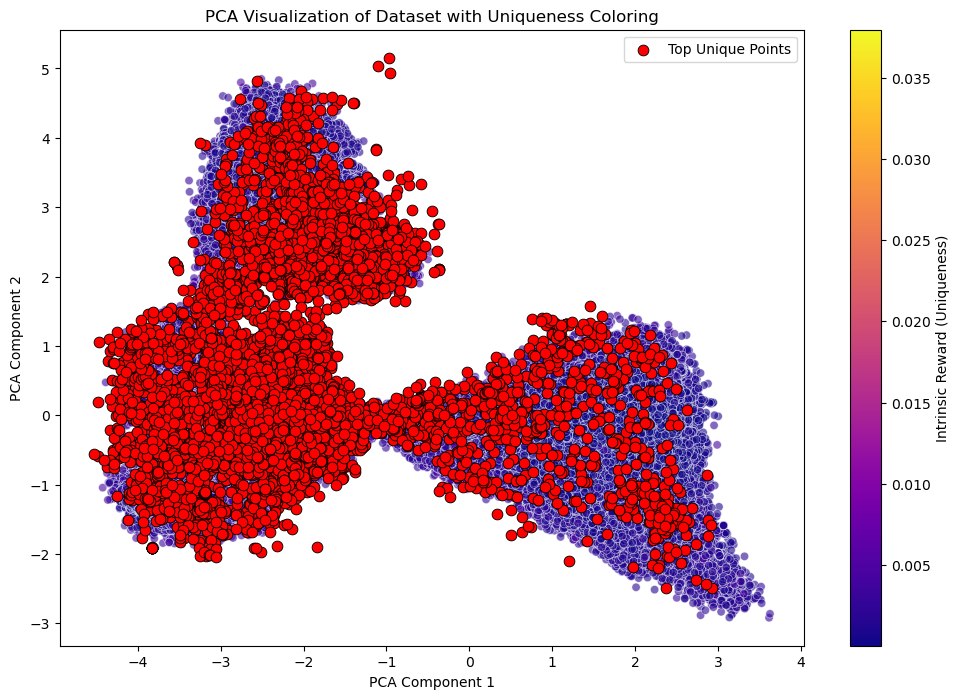

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_pca_result = pca.transform(top_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制最独特的点，用红色标注
sns.scatterplot(
    x=top_pca_result[:, 0], y=top_pca_result[:, 1],
    color="red", label="Top Unique Points", s=60, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

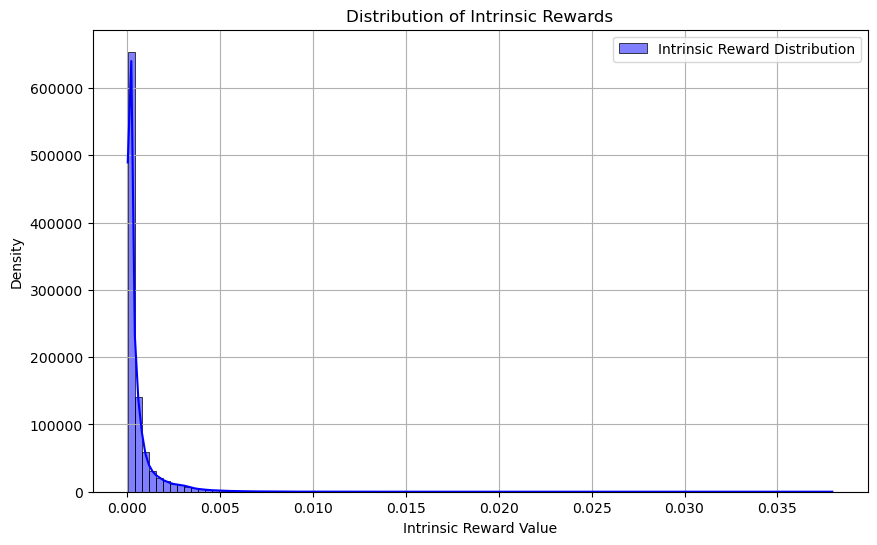

In [51]:
# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TODO : 根据原子的内在奖励值，提取最独特的结构
# 如果使用mean，一定程度上就回到了结构描述符
# 如何利用原子的独特信息？需要讨论